# Introduction

TODO


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding, Lambda, Concatenate, Reshape
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from keras.models import load_model
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import re
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            if (len(sents) < 2):
                continue             
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index].strip() + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        for row in open(file_name, encoding='utf8'):
        #for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                if (len(sents) < 2):
                    continue                 
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1].strip() + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_words_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:       
        for word in word_tokenize(sentence):
            word = process_word(word)
            if word not in vocab_to_int:
                vocab_to_int[word] = count
                count += 1


    '''''Build inverse translation from int to word'''
    int_to_vocab = {}
    for word, value in vocab_to_int.items():
        int_to_vocab[value] = word
        
    return vocab_to_int, int_to_vocab

In [10]:
def build_chars_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [11]:
def vectorize_char_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_encoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t] = vocab_to_int[char]
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t] = vocab_to_int[char]
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [12]:
def vectorize_words_data(input_texts, target_texts, max_words_seq_length, max_chars_seq_length, num_char_tokens, num_word_tokens, word2int, char2int):

    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    # 
    encoder_char_input_data = np.zeros(
    (len(input_texts), max_words_seq_length, max_chars_seq_length),
    dtype='float32')
    
    decoder_word_input_data = np.zeros(
        (len(input_texts), max_words_seq_length),
        dtype='float32')
    
    decoder_word_target_data = np.zeros(
        (len(input_texts), max_words_seq_length, num_word_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        words_lst = word_tokenize(input_text)
        if(len(words_lst) > max_words_seq_length):
            continue
        for j, word in enumerate(words_lst):
            if(len(word) > max_chars_seq_length):
                continue
            for k, char in enumerate(word):
                # c0..cn
                if(char in char2int):
                    encoder_char_input_data[i, j, k] = char2int[char]
                    
        words_lst = word_tokenize(target_text)# word_tokenize removes the \t and \n, we need them to start and end a sequence
        words_lst.insert(0, '\t')
        words_lst.append('\n')        
        if(len(words_lst) > max_words_seq_length):
            continue                
        for j, word in enumerate(words_lst):
            processed_word = process_word(word)
            if not processed_word in word2int:
                continue
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_word_input_data[i, j] = word2int[processed_word]
            if j > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_word_target_data[i, j - 1, word2int[processed_word]] = 1.
                
    return encoder_char_input_data, decoder_word_input_data, decoder_word_target_data

In [13]:
def vectorize_sentences_data(input_texts, target_labels, max_sents_per_doc, max_words_per_sent, max_chars_per_word, 
                             num_classes, char2int):

    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    # 
    hier_input_data = np.zeros((len(input_texts), 
                                max_sents_per_doc, 
                                max_words_per_sent, 
                                max_chars_per_word), dtype='float32')
    
        
    hier_target_data = np.zeros((len(input_texts), num_classes), dtype='float32')

    # TODO: input_texts = data_train.review, target_labels = data_train.label
    for i, (input_text, target_label) in enumerate(zip(input_texts, target_labels)):
        sents_lst = sent_tokenize(clean_str(BeautifulSoup(input_text).get_text())) # TODO: Move to clean str
        
        '''
        if len(sents_lst) > max_sents_per_doc:
            continue
        '''
        for j, sent in enumerate(sents_lst):
                
            words_lst = word_tokenize(input_text)
            '''
            if(len(words_lst) > max_words_per_sent):
                continue
            '''
            
            for k, word in enumerate(words_lst):
                
                '''
                if(len(word) > max_chars_per_word):
                    continue
                '''
                for l, char in enumerate(word):
                    # c0..cn
                    if(char in char2int):
                        hier_input_data[i, j, k, l] = char2int[char]
                        hier_target_data[i, target_label] = 1

                
    return hier_input_data, hier_target_data

In [14]:
def decode_gt_sequence(input_seq, int_to_vocab):

    decoded_sentence = ''
    for i in range(input_seq.shape[1]):
        
        # Sample a token
        sampled_token_index = input_seq[0][i]
        sampled_word = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_word + ' '

    return decoded_sentence

In [15]:
def decode_words_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, max_words_seq_len))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []

    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    i = 0
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
       
        
        #orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(word_tokenize(decoded_sentence)) > max_words_seq_len):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        '''
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        '''
        decoded_sentence += sampled_char + ' '


        # Update the target sequence (of length 1).
        #target_seq = np.zeros((1, max_words_seq_len))
        if i < max_words_seq_len:
            target_seq[0, i] = sampled_token_index

        # Update states
        states_value = [h, c]
        i += 1
        #if i > 48:
        #    i = 0
        

    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [16]:
def decode_char_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    encoder_outputs, h, c  = encoder_model.predict(input_seq)
    states_value = [h,c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_to_int['\t']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    #print(input_seq)
    attention_density = []
    i = 0
    special_chars = ['\\', '/', '-', '—' , ':', '[', ']', ',', '.', '"', ';', '%', '~', '(', ')', '{', '}', '$']
    while not stop_condition:
        #print(target_seq)
        output_tokens, attention, h, c  = decoder_model.predict(
            [target_seq, encoder_outputs] + states_value)
        #print(attention.shape)
        attention_density.append(attention[0][0])# attention is max_sent_len x 1 since we have num_time_steps = 1 for the output
        # Sample a token
        #print(output_tokens.shape)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        #print(sampled_token_index)
        sampled_char = int_to_vocab[sampled_token_index]
        orig_char = int_to_vocab[int(input_seq[:,i][0])]
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
            sampled_char = ''

        # Copy digits as it, since the spelling corrector is not good at digit corrections
        if(orig_char.isdigit() or orig_char in special_chars):
            decoded_sentence += orig_char            
        else:
            if(sampled_char.isdigit() or sampled_char in special_chars):
                decoded_sentence += ''
            else:
                decoded_sentence += sampled_char
        


        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        
        i += 1
        if(i > 48):
            i = 0
    attention_density = np.array(attention_density)
    return decoded_sentence, attention_density


In [17]:
def build_char_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)    
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    #print(encoder_states)
    
    decoder_inputs = Input(shape=(None,))
    decoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    #print(decoder_outputs)
    #print(encoder_outputs)
    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax', name='attention')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_encoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    #print('encoder-decoder  model:')
    print(model.summary()) 
    
    #print(encoder_inputs)
    #print(encoder_outputs)
    #print(encoder_states)
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)
    #print(encoder_outputs.shape)
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_word_embedding_model = Model(input=encoder_inputs, output=encoder_embedding_output)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(None, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model, encoder_word_embedding_model

In [18]:
def build_hier_model(encoder_word_embedding_model, max_words_seq_len, max_char_seq_len, num_word_tokens, num_char_tokens, latent_dim):
    # Define an input sequence and process it.

    inputs = Input(shape=(max_words_seq_len, max_char_seq_len,), dtype='float32')
    decoder_inputs_words = Input(shape=(max_words_seq_len,), dtype='float32')
    words_states = []
    '''
    for w in range(max_words_seq_len):
        
        encoder_char_inputs = Lambda(lambda x: x[:,w,:])(inputs)
        _, h, c = encoder_char_model(encoder_char_inputs)
        encoder_chars_states = Concatenate()([h,c])
        #print(encoder_chars_states)
        encoder_chars_states = Reshape((1,latent_dim*4))(encoder_chars_states)
        words_states.append(encoder_chars_states)
    
    input_words = Concatenate(axis=-2)(words_states)

    '''
    #input_words = TimeDistributed(Dense(10))(inputs)

    input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

    encoder_inputs_ = input_words   
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    
    decoder_inputs = decoder_inputs_words
    decoder_inputs_ = Embedding(num_word_tokens, latent_dim*4,                           
                            #weights=[np.eye(num_word_tokens)],
                            mask_zero=True, trainable=True)(decoder_inputs)    
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs_, initial_state=encoder_states)

    att_dot = Dot(axes=[2, 2])
    attention = att_dot([decoder_outputs, encoder_outputs])
    att_activation = Activation('softmax')
    attention = att_activation(attention)
    #print('attention', attention)
    context_dot = Dot(axes=[2,1])
    context = context_dot([attention, encoder_outputs])
    #print('context', context)
    att_context_concat = Concatenate()
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)

    decoder_dense = Dense(num_word_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([inputs, decoder_inputs_words], decoder_outputs)
    #model = Model(decoder_inputs, decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    
    #encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
    encoder_model = Model(input=inputs, output=[encoder_outputs] + encoder_states)
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_sentence_embedding_model = Model(input=inputs, output=encoder_embedding_output)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_encoder_inputs = Input(shape=(max_words_seq_len, latent_dim*2,))
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    
    # Equation (7) with 'dot' score from Section 3.1 in the paper.
    # Note that we reuse Softmax-activation layer instead of writing tensor calculation
    
    attention = att_dot([decoder_outputs, decoder_encoder_inputs])
    
    attention = att_activation(attention)
    #print('attention', attention)
    
    context = context_dot([attention, decoder_encoder_inputs])
    #print('context', context)
    
    
    
    decoder_combined_context = att_context_concat([context, decoder_outputs])
    #print('decoder_combined_context', decoder_combined_context)

    # Has another weight + tanh layer as described in equation (5) of the paper
    #decoder_outputs = TimeDistributed(Dense(64, activation="tanh"))(decoder_combined_context)
    #decoder_outputs = TimeDistributed(Dense(num_encoder_tokens, activation="softmax"))(decoder_outputs)
    
    #decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    #decoder_outputs = decoder_dense(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_combined_context)
    
    decoder_model = Model(
        [decoder_inputs_words, decoder_encoder_inputs] + decoder_states_inputs,
        [decoder_outputs, attention] + decoder_states)
    
    return model, encoder_model, decoder_model, encoder_sentence_embedding_model

In [19]:

def visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab):

    encoder_input_data = np.zeros((1, max_encoder_seq_length), dtype='float32')
    
    for t, char in enumerate(text):
        # c0..cn
        encoder_input_data[0, t] = vocab_to_int[char]

    input_seq = encoder_input_data[0:1]

    decoded_sentence, attention_density = decode_words_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = sns.heatmap(attention_density[:, : len(text) + 2],
        xticklabels=[w for w in text],
        yticklabels=[w for w in decoded_sentence])

    ax.invert_yaxis()
    plt.show()
    
    return decoded_sentence

In [20]:
def process_word(word):
    # Try to correct the word from known dict
    #word = spell(word)
    # Option 1: Replace special chars and digits
    #processed_word = re.sub(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', r'', w.lower())
    
    # Option 2: skip all words with special chars or digits
    if(len(re.findall(r'[\\\/\-\—\:\[\]\,\.\"\;\%\~\(\)\{\}\$\#\?\●\@\+\-\*\d]', word.lower())) == 0):
        #processed_word = word.lower()
        processed_word = word
    else:
        processed_word = 'UNK'

    # Skip stop words
    #stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]        
    stop_words = []
    if processed_word in stop_words:
        processed_word = 'UNK'
        
    return processed_word


In [21]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

# Pre-train char model

## Load data

In [22]:
'''
data_path = '../../dat/'
max_sent_len = 50
min_sent_len = 0
'''

"\ndata_path = '../../dat/'\nmax_sent_len = 50\nmin_sent_len = 0\n"

In [23]:
'''
num_samples = 1000
input_texts = []
target_texts = []
files_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_32.txt', 'field_class_30.txt']
desired_file_sizes = [num_samples, num_samples, num_samples, num_samples]
noise_threshold = 0.9

for file_name, num_file_samples in zip(files_list, desired_file_sizes):
    tess_correction_data = os.path.join(data_path, file_name)
    input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_noise(tess_correction_data, num_file_samples, noise_threshold, max_sent_len, min_sent_len)

    input_texts += input_texts_OCR
    target_texts += target_texts_OCR

'''    

"\nnum_samples = 1000\ninput_texts = []\ntarget_texts = []\nfiles_list = ['all_ocr_data_2.txt', 'field_class_21.txt', 'field_class_32.txt', 'field_class_30.txt']\ndesired_file_sizes = [num_samples, num_samples, num_samples, num_samples]\nnoise_threshold = 0.9\n\nfor file_name, num_file_samples in zip(files_list, desired_file_sizes):\n    tess_correction_data = os.path.join(data_path, file_name)\n    input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_noise(tess_correction_data, num_file_samples, noise_threshold, max_sent_len, min_sent_len)\n\n    input_texts += input_texts_OCR\n    target_texts += target_texts_OCR\n\n"

In [24]:
#len(input_texts)

In [25]:
data_path = '../../dat/'
data_file = 'imdb/labeledTrainData.tsv'

In [26]:
data_train = pd.read_csv(os.path.join(data_path, data_file), sep='\t')
print(data_train.shape)
data_train.head()

(25000, 3)


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [27]:
'''
for text in data_train.review:
    for sent in sent_tokenize(clean_str(BeautifulSoup(text).get_text())):
        print(sent + '\n')
        for word in word_tokenize(sent):
            print(word + '\n')
    print('****************\n')
'''

"\nfor text in data_train.review:\n    for sent in sent_tokenize(clean_str(BeautifulSoup(text).get_text())):\n        print(sent + '\n')\n        for word in word_tokenize(sent):\n            print(word + '\n')\n    print('****************\n')\n"

### Histogram of lenghts

In [28]:

chars_per_words_lengths = []
words_per_sents_lengths = []
sents_per_docs_lengths = []

# Chars per word should be on all text
for text in data_train.review:
    
    sents = sent_tokenize(clean_str(BeautifulSoup(text).get_text()))
    sents_per_docs_lengths.append(len(sents))
    for sent in sents:       
    
        words = word_tokenize(text)
        words_per_sents_lengths.append(len(words))
        for word in words:
            chars_per_words_lengths.append(len(word))

    

/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


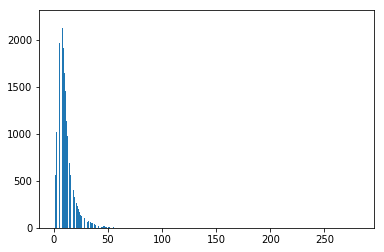

In [29]:
h_s = plt.hist(sents_per_docs_lengths, bins=500)

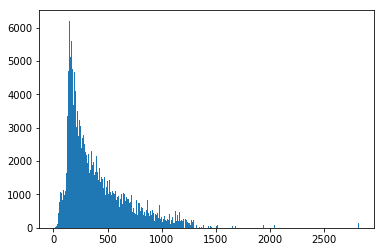

In [30]:
h_w = plt.hist(words_per_sents_lengths, bins=500)

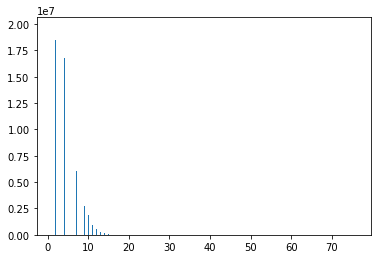

In [31]:
h_c = plt.hist(chars_per_words_lengths, bins=500)

## Build char vocab (all text)

In [32]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_chars_vocab(all_texts)
np.savez('vocab_char-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )
char2int = vocab_to_int
int2char = int_to_vocab

NameError: name 'target_texts' is not defined

In [ ]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [ ]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

In [ ]:
#char2int

In [ ]:
#int2char

In [ ]:
len(int_to_vocab)

## Vectorize char data

In [ ]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_char_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

## Build char model

In [ ]:
latent_dim = 256 

In [ ]:
model, encoder_model, decoder_model, encoder_word_embedding_model = build_char_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

In [ ]:
encoder_model.summary()

## Fit char model

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 1  
lr = 0.01

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model_char-{}.hdf5".format(max_sent_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

In [ ]:
encoder_char_model_file = 'encoder_char_model-{}.hdf5'
decoder_char_model_file = 'decoder_char_model-{}.hdf5'
encoder_model.save('encoder_char_model-{}.hdf5'.format(max_sent_len))
decoder_model.save('decoder_char_model-{}.hdf5'.format(max_sent_len))

# Pre-train words model

## Build word vocab (target_texts)

In [ ]:
max_words_seq_len=15
max_chars_seq_len=20

In [ ]:
all_texts = target_texts
vocab_to_int, int_to_vocab = build_words_vocab(all_texts)
word2int = vocab_to_int
int2word = int_to_vocab
np.savez('vocab_hier-{}-{}'.format(max_words_seq_len, max_chars_seq_len), char2int=char2int, int2char=int2char, word2int=word2int, int2word=int2word, max_words_seq_len=max_words_seq_len, max_char_seq_len=max_chars_seq_len)


In [ ]:
word2int

In [ ]:
int2word

In [ ]:
num_word_tokens=len(sorted(list(word2int)))
num_char_tokens=len(sorted(list(char2int)))

## Vecotrize words data

In [ ]:
encoder_char_input_data, decoder_word_input_data, decoder_word_target_data = vectorize_words_data(input_texts, 
                                                                                                target_texts, 
                                                                                                max_words_seq_len, 
                                                                                                max_chars_seq_len, 
                                                                                                num_char_tokens, 
                                                                                                num_word_tokens, 
                                                                                                word2int, 
                                                                                                char2int)

## Load char encoder

In [ ]:
encoder_char_model = load_model(encoder_char_model_file.format(max_sent_len))

## Build words model

In [ ]:
encoder_word_embedding_model.summary()

In [ ]:
model, encoder_model, decoder_model, encoder_sentence_embedding_model = build_hier_model(encoder_word_embedding_model=encoder_word_embedding_model, 
                              max_words_seq_len=max_words_seq_len,
                              max_char_seq_len=max_chars_seq_len,
                              num_word_tokens=num_word_tokens,
                              num_char_tokens=num_char_tokens, 
                              latent_dim=latent_dim)

In [ ]:
encoder_model.summary()

In [ ]:
decoder_model.summary()

In [ ]:
encoder_sentence_embedding_model.summary()

## Fit words model

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 1
lr = 0.01

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_hier_model-{}-{}.hdf5".format(max_words_seq_len,max_chars_seq_len) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]
model.fit([encoder_char_input_data, decoder_word_input_data], decoder_word_target_data,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

In [ ]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_char_input_data[seq_index: seq_index + 1]
    target_seq = np.argmax(decoder_word_target_data[seq_index: seq_index + 1], axis=-1)
    #print(target_seq)
    
    decoded_sentence, _ = decode_words_sequence(input_seq, encoder_model, decoder_model, max_words_seq_len, num_word_tokens, int2word)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

# Train sentences model

# Load documents data

In [ ]:

MAX_SENTS_PER_DOC = 15
MAX_WORDS_PER_SENT = 40
MAX_CHARS_PER_WORD = 20
NUM_CLASSES = 2

EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [ ]:
data_train.head()

In [ ]:
'''
for text in data_train.review:
    for sent in sent_tokenize(clean_str(BeautifulSoup(text).get_text())):
        print(sent + '\n')
        for word in word_tokenize(sent):
            print(word + '\n')
    print('****************\n')
'''

# Vectorize documents data

In [ ]:
hier_input_data, hier_input_targets = vectorize_sentences_data(input_texts=data_train.review, 
                                                               target_labels=data_train.sentiment, 
                                                               max_sents_per_doc=MAX_SENTS_PER_DOC, 
                                                               max_words_per_sent=MAX_WORDS_PER_SENT, 
                                                               max_chars_per_word=MAX_CHARS_PER_WORD, 
                                                               num_classes=NUM_CLASSES, 
                                                               char2int=char2int)